In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Load data
xls = pd.ExcelFile('./uploads/TransactionLogs_Jan2025-June2025.xlsx')
df_tx = pd.read_excel(xls, sheet_name='2025.1-6')
df_cp = pd.read_excel(xls, sheet_name='ChargePointDB')

# Display sample of charger database
# tools.display_dataframe_to_user("ChargePointDB Sample", df_cp.head())
df_cp.head()

,OperationalDate,Contract,SiteName,SiteAddress,Zone,ChargeBoxId,EvseId,Vendor,Model,Current,MaxPower
0,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1136,264352,StarCharge,Artemis,AC,7.4
1,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1137,264353,StarCharge,Artemis,AC,7.4
2,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1138,264354,StarCharge,Artemis,AC,7.4
3,2025-07-09 00:00:00,Public (TD116),"Blk 723 Yishun Street 71 Lot 363, 364, 365, 36...","723 Yishun Street 71, Singapore 760723",North,SCAC1109,264323,StarCharge,Artemis,AC,7.4
4,2025-07-09 00:00:00,Public (TD116),"Blk 723 Yishun Street 71 Lot 363, 364, 365, 36...","723 Yishun Street 71, Singapore 760723",North,SCAC1110,264324,StarCharge,Artemis,AC,7.4


In [ ]:
# Feature engineering
df_tx['session_duration_h'] = (df_tx['StopTime'] - df_tx['StartTime']).dt.total_seconds() / 3600
df_tx['avg_power_kW'] = df_tx['Energy'] / df_tx['session_duration_h'].replace(0, np.nan)

user_stats = df_tx.groupby('CustomerId').agg(
    total_sessions=('ChargeId','count'),
    total_energy=('Energy','sum'),
    avg_energy=('Energy','mean'),
    avg_duration=('session_duration_h','mean'),
    dc_sessions=('Current', lambda x: (x=='DC').sum())
).reset_index()
user_stats['dc_fraction'] = user_stats['dc_sessions'] / user_stats['total_sessions']
user_stats = user_stats.merge(
    df_tx.groupby('CustomerId')['ChargeBoxId'].nunique().rename('unique_chargers'),
    on='CustomerId'
)
user_stats['loyalty_ratio'] = user_stats['total_sessions'] / user_stats['unique_chargers']

# Prepare features
features = ['total_sessions','total_energy','avg_energy','avg_duration','dc_fraction','loyalty_ratio']
X = user_stats[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

clusterer = DBSCAN(eps=0.1,
                   min_samples=10,
                   algorithm='auto')

user_stats['primary_cluster'] = clusterer.fit_predict(X_scaled)
user_stats[['CustomerId','primary_cluster']+features].head(20)

,CustomerId,primary_cluster,total_sessions,total_energy,avg_energy,avg_duration,dc_fraction,loyalty_ratio
0,00HLAS76E7,-1,10,226.171,22.617100,0.628556,1.000000,2.500000
1,0434C50AD86380,-1,20,449.555,22.477750,2.767319,0.350000,5.000000
2,04493232C05B85,-1,119,2691.941,22.621353,0.660378,1.000000,9.153846
3,045FFA0AD86380,0,1,25.261,25.261000,0.539722,1.000000,1.000000
4,0490C70AD86380,-1,6,96.042,16.007000,0.531806,1.000000,1.500000
5,04948A12126884,-1,36,481.750,13.381944,0.459429,0.833333,3.272727
6,04CAD732C05B80,0,3,74.192,24.730667,0.708148,1.000000,1.500000
7,04F42B0AD86380,1,3,64.090,21.363333,3.340926,0.000000,1.500000
8,0A809933,-1,50,1355.997,27.119940,0.715294,1.000000,50.000000
9,0G5O9F1V60,-1,70,2243.125,32.044643,0.884377,0.985714,7.000000


In [6]:

cluster_summary = user_stats.groupby('primary_cluster')[features].mean().reset_index()
cluster_summary

,primary_cluster,total_sessions,total_energy,avg_energy,avg_duration,dc_fraction,loyalty_ratio
0,-1,24.439102,642.385877,27.824542,5.555834,0.269464,5.430700
1,0,1.153138,33.962964,29.521940,0.633817,1.000000,1.006597
2,1,2.153974,30.569140,14.630578,2.582993,0.000000,1.191683
3,2,2.450142,47.506125,19.422501,0.995509,0.500000,1.047009
4,3,1.000000,0.660818,0.660818,0.027828,1.000000,1.000000
5,4,2.498039,74.046420,29.372593,0.616600,1.000000,1.987255
6,5,3.518182,56.928455,16.161344,1.173970,0.333333,1.055422
7,6,3.782609,89.462957,23.607614,0.538702,1.000000,3.000000
8,7,4.275862,56.060483,13.225907,1.115447,0.250000,1.087849
9,8,7.190476,226.397952,31.445259,4.931586,0.000000,2.452381


In [7]:
# Save results
output_path = './Outputs/user_primary_personas.csv'
user_stats.to_csv(output_path, index=False)

In [15]:
df = pd.read_excel('./uploads/TransactionLogs_Jan2025-June2025_updated.xlsx', sheet_name='ChargePointDB')
df.head()

,OperationalDate,Contract,SiteName,SiteAddress,Zone,ChargeBoxId,EvseId,Vendor,Model,Current,MaxPower
0,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1136,264352,StarCharge,Artemis,AC,7.4
1,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1137,264353,StarCharge,Artemis,AC,7.4
2,2025-07-09 00:00:00,Public (TD116),"Blk 152 Ang Mo Kio Avenue 5 Lot 217, 218 & 219...","152 Ang Mo Kio Ave 5, Singapore 560152",North,SCAC1138,264354,StarCharge,Artemis,AC,7.4
3,2025-07-09 00:00:00,Public (TD116),"Blk 723 Yishun Street 71 Lot 363, 364, 365, 36...","723 Yishun Street 71, Singapore 760723",North,SCAC1109,264323,StarCharge,Artemis,AC,7.4
4,2025-07-09 00:00:00,Public (TD116),"Blk 723 Yishun Street 71 Lot 363, 364, 365, 36...","723 Yishun Street 71, Singapore 760723",North,SCAC1110,264324,StarCharge,Artemis,AC,7.4


In [17]:
# pd.merge(
#          user_stats,
#          df,
#          on='CustomerId',
#          how='left')
user_stats

,CustomerId,total_sessions,total_energy,avg_energy,avg_duration,dc_sessions,dc_fraction,unique_chargers,loyalty_ratio,primary_cluster
0,00HLAS76E7,10,226.171,22.617100,0.628556,10,1.000000,4,2.500000,-1
1,0434C50AD86380,20,449.555,22.477750,2.767319,7,0.350000,4,5.000000,-1
2,04493232C05B85,119,2691.941,22.621353,0.660378,119,1.000000,13,9.153846,-1
3,045FFA0AD86380,1,25.261,25.261000,0.539722,1,1.000000,1,1.000000,0
4,0490C70AD86380,6,96.042,16.007000,0.531806,6,1.000000,4,1.500000,-1
...,...,...,...,...,...,...,...,...,...,...
19939,zyUbxjdXxR,31,532.193,17.167516,0.583754,29,0.935484,9,3.444444,-1
19940,zyXrZqtBcO,1,11.504,11.504000,1.449167,0,0.000000,1,1.000000,1
19941,zywjFHDwCq,76,1350.842,17.774237,3.539656,6,0.078947,8,9.500000,-1
19942,zzJrxXUSfn,20,979.106,48.955300,8.973333,0,0.000000,2,10.000000,-1


In [ ]:
# !uv add requests geopy shapely
# !uv add tqdm

Resolved 70 packages in 145ms                                        
Installed 1 package in 9ms                                       
 + tqdm==4.67.1


In [ ]:
import pandas as pd
import time
import requests
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from shapely.ops import nearest_points
import math

# 1) Load your ChargePointDB
df_cp = df.copy()

# 2) Geocode unique SiteAddress → latitude, longitude
geolocator = Nominatim(user_agent="ev_v2g")
coords = {}
for addr in df_cp['SiteAddress'].unique():
    try:
        loc = geolocator.geocode(addr)
        coords[addr] = (loc.latitude, loc.longitude) if loc else (None, None)
    except Exception:
        coords[addr] = (None, None)
    time.sleep(1)  # Nominatim policy: 1 req/sec

df_cp['lat'] = df_cp['SiteAddress'].map(lambda a: coords[a][0])
df_cp['lon'] = df_cp['SiteAddress'].map(lambda a: coords[a][1])

# 3) Overpass query function
OVERPASS_URL = "https://overpass-api.de/api/interpreter"

def fetch_pois(lat: float, lon: float, radius: int = 1500) -> list:
    """
    Fetch POIs within a radius of a given latitude and longitude.

    Args:
        lat (float): Latitude of the center point
        lon (float): Longitude of the center point
        radius (int): Radius in meters

    Returns:
        list: List of tuples containing POI name, category, latitude, longitude, and distance from the center point
    """
    # search for multiple categories
    query = f"""
    [out:json][timeout:25];
    (
      node["amenity"="hospital"](around:{radius},{lat},{lon});
      node["shop"="mall"](around:{radius},{lat},{lon});
      node["amenity"="school"](around:{radius},{lat},{lon});
      way["landuse"="industrial"](around:{radius},{lat},{lon});
      way["landuse"="residential"](around:{radius},{lat},{lon});
    );
    out center;
    """
    resp = requests.post(OVERPASS_URL, data={'data': query})
    data = resp.json()['elements']
    pois = []
    for el in data:
        # get geometry
        if 'lat' in el:
            plat, plon = el['lat'], el['lon']
        else:
            plat, plon = el['center']['lat'], el['center']['lon']
        
        # compute haversine distance
        def haversine(a: tuple, b: tuple) -> float:
            """
            Calculate the haversine distance between two points on the Earth's surface.
            Used for distance calculation between two latitude and longitude coordinates.

            Args:
                a (tuple): (latitude, longitude) of point A
                b (tuple): (latitude, longitude) of point B

            Returns:
                float: Distance in meters
            """
            # Earth's radius in meters
            R=6371000

            phi1, phi2 = math.radians(a[0]),math.radians(b[0])
            dphi, dlambda = math.radians(b[0]-a[0]),math.radians(b[1]-a[1])

            d = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2

            return 2*R*math.asin(math.sqrt(d))
        
        dist = haversine((lat,lon),(plat,plon))
        name = el['tags'].get('name','')
        category = (
            'hospital' if el['tags'].get('amenity')=='hospital' else
            'school'   if el['tags'].get('amenity')=='school'   else
            'mall'     if el['tags'].get('shop')=='mall'         else
            'industrial' if el['tags'].get('landuse')=='industrial' else
            'residential'
        )
        pois.append((name, category, plat, plon, dist))
    # return 5 nearest
    pois.sort(key=lambda x: x[4])
    return pois[:5]

In [27]:
from tqdm import tqdm

# 4) Build landmark lookup
records = []
i = 0

for _, row in tqdm(df_cp.drop_duplicates(subset='ChargeBoxId').iterrows()):
    if pd.notna(row.lat):
        try:
            nearest = fetch_pois(row.lat, row.lon)
        except Exception as e:
            print(f"Error fetching POIs for {row.ChargeBoxId}: {e}")
            nearest = []
    else:
        nearest = []
    i += 1
    if i % 100 == 0:
        print(f"{i}/{len(df_cp.drop_duplicates(subset='ChargeBoxId'))}")

    for name, cat, plat, plon, dist in nearest:
        records.append({
            'ChargeBoxId': row.ChargeBoxId,
            'LandmarkName': name,
            'Category': cat,
            'Lat': plat,
            'Lon': plon,
            'Distance_m': dist
        })

landmarks_df = pd.DataFrame(records)
landmarks_df.to_csv('./Outputs/charger_landmarks.csv', index=False)

print("Done: saved charger_landmarks.csv")

100/1335


200/1335


300/1335


400/1335


500/1335


600/1335


700/1335


800/1335


900/1335


1000/1335


Error fetching POIs for wbac0132: Expecting value: line 1 column 1 (char 0)


1100/1335


1200/1335


1300/1335


1335it [17:43,  1.26it/s]

Done: saved charger_landmarks.csv


In [30]:
landmarks_df.isna().sum()
landmarks_df

,ChargeBoxId,LandmarkName,Category,Lat,Lon,Distance_m
0,SCAC1136,Yio Chu Kang Grove,residential,1.376055,103.840903,107.135834
1,SCAC1136,,residential,1.378458,103.842141,295.548588
2,SCAC1136,Kebun Baru Link,residential,1.375671,103.837260,342.007170
3,SCAC1136,Yio Chu Kang Green,residential,1.379362,103.837166,447.634788
4,SCAC1136,,residential,1.371916,103.839673,532.292569
...,...,...,...,...,...,...
2321,NaN,,residential,34.226222,70.387870,969.585346
2322,NaN,,residential,34.225915,70.389908,1096.388673
2323,NaN,,residential,34.225205,70.391324,1168.211523
2324,NaN,,residential,34.231696,70.385822,1365.285921


In [ ]:
user_personas = pd.read_csv('./Outputs/user_primary_personas.csv')
charger_landmarks = pd.read_csv('./Outputs/charger_landmarks.csv')
xls = pd.ExcelFile('./uploads/TransactionLogs_Jan2025-June2025.xlsx')
df_tx = pd.read_excel(xls, sheet_name='2025.1-6')

# 1️⃣ Compute frequency per user/charger
user_ch_counts = df_tx.groupby(['CustomerId','ChargeBoxId']).size().reset_index(name='count')

# 2️⃣ Compute each user’s 90th percentile threshold
percentiles = user_ch_counts.groupby('CustomerId')['count'] \
    .quantile(0.9).reset_index().rename(columns={'count':'p90'})

# 3️⃣ Identify top chargers (>= p90)
top = pd.merge(user_ch_counts, percentiles, on='CustomerId')
user_top = top[top['count'] >= top['p90']]

# 4️⃣ Map top chargers to landmarks
top_landmarks = pd.merge(user_top[['CustomerId','ChargeBoxId']],
                         charger_landmarks,
                         on='ChargeBoxId', how='left')

# 5️⃣ Derive secondary persona (most frequent landmark category per user)
sec = top_landmarks.groupby(['CustomerId','Category']).size().reset_index(name='n')
sec = sec.loc[sec.groupby('CustomerId')['n'].idxmax()]
sec = sec[['CustomerId','Category']].rename(columns={'Category':'secondary_persona'})

# 6️⃣ Merge back to full persona table
user_full = pd.merge(user_personas, sec, on='CustomerId', how='left')

# 7️⃣ Correlation per charger_id
merged = pd.merge(df_tx[['CustomerId','ChargeBoxId']],
                  user_full[['CustomerId','primary_cluster','secondary_persona']],
                  on='CustomerId', how='left')
charger_corr = merged.groupby('ChargeBoxId').agg(
    primary_mode=('primary_cluster', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    secondary_mode=('secondary_persona', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    user_count=('CustomerId','nunique')
).reset_index()

# Save outputs
user_full.to_csv('./Outputs/user_full_personas.csv', index=False)
charger_corr.to_csv('./Outputs/charger_persona_correlation.csv', index=False)

Exception ignored in: <function tqdm.__del__ at 0x133715630>
Traceback (most recent call last):
  File "/Users/aamirsyedaltaf/Documents/v2g-eda/.venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/aamirsyedaltaf/Documents/v2g-eda/.venv/lib/python3.10/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [32]:
sec.head(20)

,CustomerId,secondary_persona
0,00HLAS76E7,residential
1,0434C50AD86380,residential
2,04493232C05B85,residential
3,0490C70AD86380,residential
5,04948A12126884,residential
6,0A809933,industrial
8,0G5O9F1V60,residential
10,1JTT5LXPG9,residential
11,2035526,residential
13,2035846,residential


In [33]:
charger_corr.head(20)

,ChargeBoxId,primary_mode,secondary_mode,user_count
0,170001681,-1.0,residential,19
1,DELDC0008,-1.0,residential,237
2,DELDC0009,-1.0,residential,214
3,DELDC0010,-1.0,residential,68
4,DELDC0014,-1.0,residential,59
5,DelAC0004,-1.0,residential,9
6,DelAC0090,-1.0,industrial,3
7,DelAC0099,1.0,residential,1
8,DelAC0145,-1.0,residential,10
9,DelAC0307,-1.0,residential,6


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Load the data sets
charger_landmarks = pd.read_csv('./Outputs/charger_landmarks.csv')
charger_persona_corr = pd.read_csv('./Outputs/charger_persona_correlation.csv')
user_full_personas = pd.read_csv('./Outputs/user_full_personas.csv')

# 1. User Segmentation
# Compute the 90th percentile of unique chargers
percentile90 = np.percentile(user_full_personas['unique_chargers'], 90)

# Label users as explorer or loyal
user_full_personas['user_type'] = np.where(
    user_full_personas['unique_chargers'] >= percentile90,
    'explorer',
    'loyal'
)

# Determine each user’s persona
def derive_user_persona(row):
    sec = row['secondary_persona']
    if pd.notna(sec) and sec != '':
        return sec
    cluster = row['primary_cluster']
    if pd.notna(cluster) and cluster != -1:
        return f'cluster_{int(cluster)}'
    return 'unknown'

user_full_personas['user_persona'] = user_full_personas.apply(derive_user_persona, axis=1)

# Final user tagging table
user_tagging_df = user_full_personas[['CustomerId', 'unique_chargers', 'user_type', 'user_persona']]
user_tagging_df = user_tagging_df.rename(columns={'CustomerId': 'user_id'})

# 2. Charger Segmentation
def derive_charger_persona(row):
    sec = row['secondary_mode']
    prim = row['primary_mode']
    # use the secondary string persona if available
    if pd.notna(sec) and sec != '' and sec != -1 and sec != -1.0:
        return sec
    # otherwise fall back to numeric cluster
    if pd.notna(prim) and prim != -1 and prim != -1.0:
        return f'cluster_{int(prim)}'
    return 'unknown'

charger_persona_corr['dominant_persona'] = charger_persona_corr.apply(derive_charger_persona, axis=1)

# Merge each charger with its nearest landmark (minimum distance)
def get_nearest_landmark(group):
    idx = group['Distance_m'].idxmin()
    return group.loc[idx]

nearest_landmarks = charger_landmarks.groupby('ChargeBoxId').apply(get_nearest_landmark).reset_index(drop=True)

# Final charger tagging table
charger_tagging_df = charger_persona_corr.merge(
    nearest_landmarks[['ChargeBoxId', 'LandmarkName', 'Category', 'Lat', 'Lon']],
    on='ChargeBoxId',
    how='left'
)
charger_tagging_df = charger_tagging_df[['ChargeBoxId', 'dominant_persona', 'LandmarkName', 'Category', 'Lat', 'Lon']]

# Save to Excel
with pd.ExcelWriter('./Outputs/user_tagging.xlsx') as writer:
    user_tagging_df.to_excel(writer, sheet_name='user_tagging', index=False)

with pd.ExcelWriter('./Outputs/charger_tagging.xlsx') as writer:
    charger_tagging_df.to_excel(writer, sheet_name='charger_tagging', index=False)

# Heatmap for geographic correlation
geo_correlation = charger_tagging_df.pivot_table(
    index='Category', columns='dominant_persona', values='ChargeBoxId',
    aggfunc='count', fill_value=0
)
plt.figure(figsize=(12, 6))
sns.heatmap(geo_correlation, annot=True, cmap='Blues')
plt.title('Geographic correlation of charger personas and landmark categories')
plt.xlabel('Charger Dominant Persona')
plt.ylabel('Landmark Category')
plt.tight_layout()
plt.show()

/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/2586307798.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nearest_landmarks = charger_landmarks.groupby('ChargeBoxId').apply(get_nearest_landmark).reset_index(drop=True)
/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/2586307798.py:87: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [20]:
plt.savefig('./Outputs/geo_correlation.png', bbox_inches='tight')

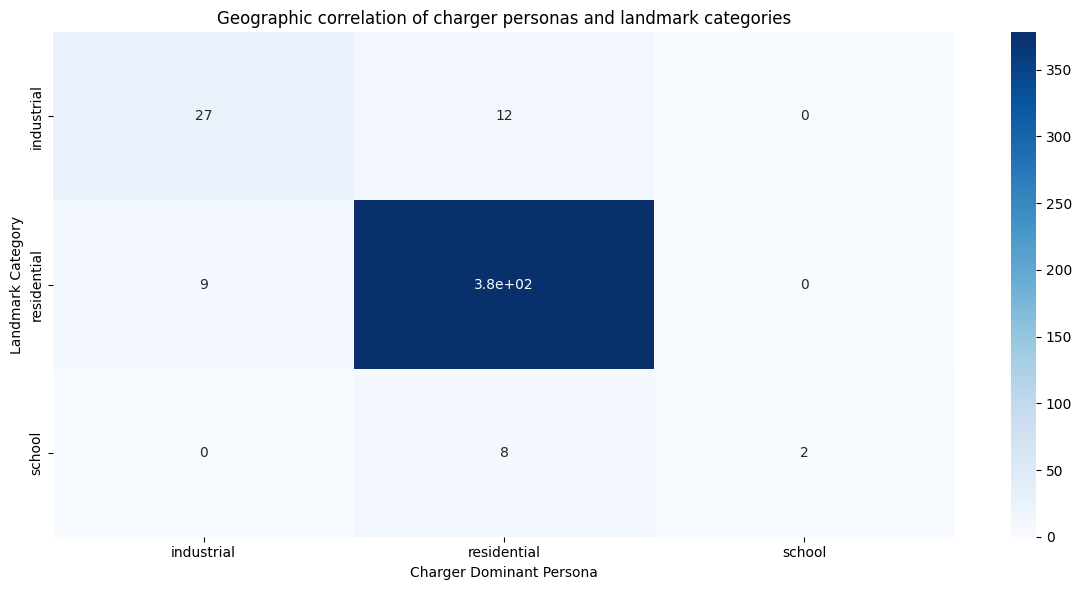

In [34]:
from PIL import Image

Image.open('./Outputs/geo_correlation.png')

In [25]:
# !uv add statsmodels

In [40]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support
from scipy.stats import norm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Load the USEP dataset
usep_path = './uploads/USEP-Data_Jan2025-June2025.csv'
df = pd.read_csv(usep_path)

# 2. Convert DATE + PERIOD to a proper timestamp
def parse_timestamp(row: pd.Series) -> datetime:
    """
    Convert 'DATE' (e.g. '01-Jun-2025') and PERIOD (1–48) to a datetime object.

    Args:
        row (pd.Series): A row from the dataframe containing DATE and PERIOD columns

    Returns:
        datetime: A datetime object representing the timestamp
    """
    date_obj = datetime.strptime(row['DATE'], '%d-%b-%Y')
    # PERIOD 1 corresponds to 00:00–00:30, so offset is (PERIOD-1)*30 minutes
    return date_obj + timedelta(minutes=(row['PERIOD'] - 1) * 30)

df['timestamp'] = df.apply(parse_timestamp, axis=1)

# Convert MAP columns to numeric (they import as object because of '-' etc.)
for col in ['MAP ($/MWh)', 'MAPT ($/MWh)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Sort the data chronologically
df_sorted = df.sort_values('timestamp').reset_index(drop=True)
df_sorted.head()

,INFORMATION TYPE,DATE,PERIOD,USEP ($/MWh),LCP ($/MWh),DEMAND (MW),SOLAR(MW),TCL (MW),RUSEP ($/MWh),MAP ($/MWh),MAPT ($/MWh),TPC Applied,timestamp
0,USEP,01-Jan-2025,1,95.85,0.0,6020.956,0.0,0.0,95.85,95.65,534.25,No,2025-01-01 00:00:00
1,USEP,01-Jan-2025,2,91.73,0.0,5862.528,0.0,0.0,91.73,95.87,534.25,No,2025-01-01 00:30:00
2,USEP,01-Jan-2025,3,93.60,0.0,5713.015,0.0,0.0,93.60,96.12,534.25,No,2025-01-01 01:00:00
3,USEP,01-Jan-2025,4,93.61,0.0,5691.569,0.0,0.0,93.61,96.39,534.25,No,2025-01-01 01:30:00
4,USEP,01-Jan-2025,5,95.52,0.0,5680.834,0.0,0.0,95.52,96.69,534.25,No,2025-01-01 02:00:00


In [43]:
# Extract the price series and timestamps
price_series = df_sorted['USEP ($/MWh)']
timestamp_series = df_sorted['timestamp']

# 3. Split into training and testing (80/20)
train_size = int(len(df_sorted) * 0.8)
train_price = price_series.iloc[:train_size]
test_price = price_series.iloc[train_size:]
train_timestamps = timestamp_series.iloc[:train_size]
test_timestamps = timestamp_series.iloc[train_size:]

# 4. Forecasting with Exponential Smoothing
# Use additive trend and daily seasonality (48 half-hour periods)
seasonal_periods = 48
es_model = ExponentialSmoothing(
    train_price,
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_periods
)
es_fit = es_model.fit()
forecast_mean = es_fit.forecast(len(test_price))

# Estimate confidence intervals using residual standard deviation
residuals = train_price - es_fit.fittedvalues
resid_std = residuals.std()
ci_lower = forecast_mean - 1.96 * resid_std
ci_upper = forecast_mean + 1.96 * resid_std

# Forecast performance metric (RMSE)
rmse = np.sqrt(mean_squared_error(test_price, forecast_mean))

# 5. High‑price probability for each forecasted interval
threshold_price = np.percentile(train_price, 90)  # 90th percentile of training prices
# P(price > threshold) assuming normal distribution with mean=forecast and std=resid_std
price_probs = 1 - norm.cdf((threshold_price - forecast_mean) / resid_std)

# 6. Anomaly detection using IsolationForest
# Build feature matrix: price, price difference, demand, solar
lag_price = price_series.shift(1).fillna(method='bfill')
diff_price = price_series - lag_price
features = pd.DataFrame({
    'price': price_series,
    'diff_price': diff_price,
    'demand': df_sorted['DEMAND (MW)'],
    'solar': df_sorted['SOLAR(MW)']
})

iso = IsolationForest(
    n_estimators=100,
    contamination=0.01,   # assume ~1% of intervals are anomalies/DR events
    random_state=42
)
iso.fit(features.iloc[:train_size])
anomaly_scores = iso.decision_function(features)
# Convert raw scores to a 0–1 anomaly probability (higher means more anomalous)
anomaly_prob = 1 - (anomaly_scores - anomaly_scores.min()) / \
    (anomaly_scores.max() - anomaly_scores.min())
# Threshold at 99th percentile of training anomaly probabilities
threshold_anomaly = np.percentile(anomaly_prob[:train_size], 99)
pred_anomalies = (anomaly_prob >= threshold_anomaly).astype(int)

# 7. Assemble results DataFrame
results_df = df_sorted[['timestamp', 'USEP ($/MWh)', 'DEMAND (MW)', 'SOLAR(MW)']].copy()
results_df.rename(columns={'USEP ($/MWh)': 'price',
                           'DEMAND (MW)': 'demand',
                           'SOLAR(MW)': 'solar'}, inplace=True)
# Populate prediction and probability columns
results_df['pred_price'] = np.nan
results_df.loc[train_size:, 'pred_price'] = forecast_mean.values
results_df['price_prob_high'] = np.nan
results_df.loc[train_size:, 'price_prob_high'] = price_probs
results_df['anomaly_prob'] = anomaly_prob
results_df['pred_anomaly'] = pred_anomalies

# Combined DR-event prediction: high price probability > 0.5 AND anomaly probability above threshold
results_df['pred_dr_event'] = 0
mask = np.arange(len(results_df)) >= train_size
results_df.loc[mask, 'pred_dr_event'] = (
    (results_df.loc[mask, 'price_prob_high'] > 0.5) &
    (results_df.loc[mask, 'anomaly_prob'] >= threshold_anomaly)
).astype(int)

# 8. Evaluate detection (using a proxy “true anomaly” defined as price above 95th percentile of training set)
true_anomaly = (results_df['price'] > np.percentile(train_price, 95)).astype(int)
true = true_anomaly[mask]
pred = results_df.loc[mask, 'pred_dr_event']
precision, recall, fscore, _ = precision_recall_fscore_support(
    true, pred, average='binary', zero_division=0
)

results_df.head()

/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/2392999513.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lag_price = price_series.shift(1).fillna(method='bfill')


,timestamp,price,demand,solar,pred_price,price_prob_high,anomaly_prob,pred_anomaly,pred_dr_event
0,2025-01-01 00:00:00,95.85,6020.956,0.0,NaN,NaN,0.003781,0,0
1,2025-01-01 00:30:00,91.73,5862.528,0.0,NaN,NaN,0.057451,0,0
2,2025-01-01 01:00:00,93.60,5713.015,0.0,NaN,NaN,0.047523,0,0
3,2025-01-01 01:30:00,93.61,5691.569,0.0,NaN,NaN,0.044969,0,0
4,2025-01-01 02:00:00,95.52,5680.834,0.0,NaN,NaN,0.064374,0,0


In [45]:
print('RMSE:', rmse)
print('Precision:', precision, 'Recall:', recall, 'F-score:', fscore)

RMSE: 146.12780637047237
Precision: 0.9444444444444444 Recall: 0.2833333333333333 F-score: 0.4358974358974359


In [46]:
# 9. Save the combined results to CSV
results_df.to_csv('./Outputs/usep_forecast_results.csv', index=False)

# 10. Plot the forecast vs actual with confidence interval
x_num = mdates.date2num(test_timestamps)
actual_y = test_price.values
pred_y = forecast_mean.values
ci_l = ci_lower.values
ci_u = ci_upper.values

plt.figure(figsize=(14, 5))
plt.plot_date(x_num, actual_y, fmt='-', label='Actual USEP')
plt.plot_date(x_num, pred_y, fmt='-', label='Predicted USEP')
plt.fill_between(x_num, ci_l, ci_u, color='lightblue',
                 alpha=0.3, label='95% Confidence Interval')
plt.title('USEP Forecasting (Exponential Smoothing)')
plt.xlabel('Timestamp')
plt.ylabel('USEP ($/MWh)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./Outputs/usep_price_forecast_plot.png', bbox_inches='tight')

/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/2210808364.py:12: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x_num, actual_y, fmt='-', label='Actual USEP')
/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/2210808364.py:13: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x_num, pred_y, fmt='-', label='Predicted USEP')


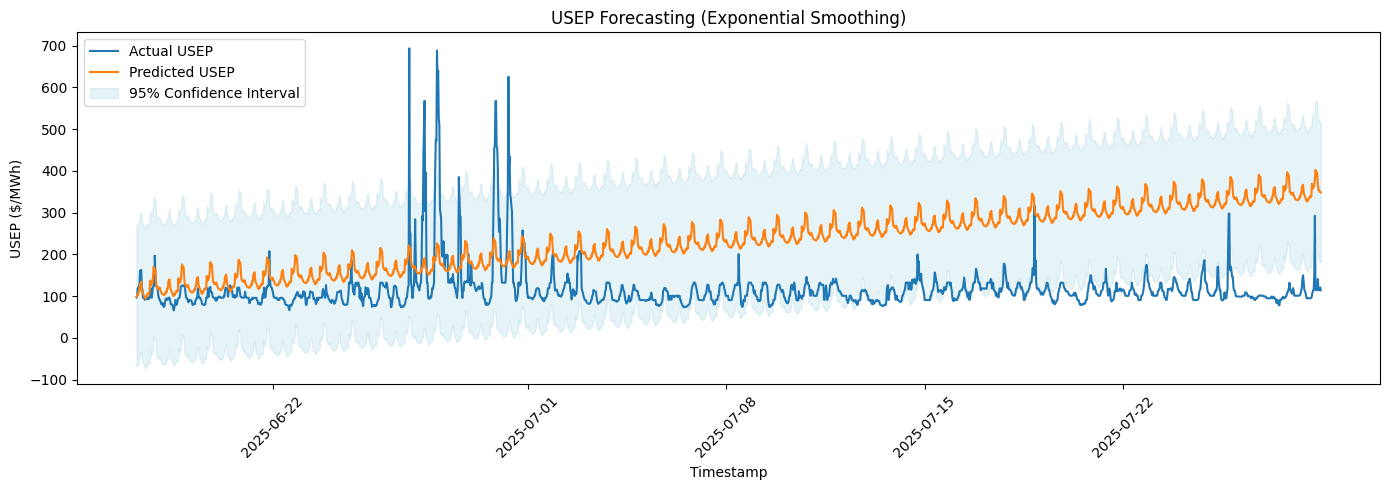

In [47]:
Image.open('./Outputs/usep_price_forecast_plot.png')

In [48]:
# 11. Plot anomaly probabilities
plt.figure(figsize=(14, 5))
full_x = mdates.date2num(results_df['timestamp'])
plt.plot_date(full_x, results_df['anomaly_prob'], fmt='-',
              label='Anomaly Probability')
plt.axhline(threshold_anomaly, color='orange',
            linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Detection Probability (USEP data)')
plt.xlabel('Timestamp')
plt.ylabel('Anomaly Probability')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./Outputs/usep_anomaly_plot.png', bbox_inches='tight')

/var/folders/tt/tv8p41yj119fzd5x9mc1mmkm0000gp/T/ipykernel_45728/1728181331.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(full_x, results_df['anomaly_prob'], fmt='-',


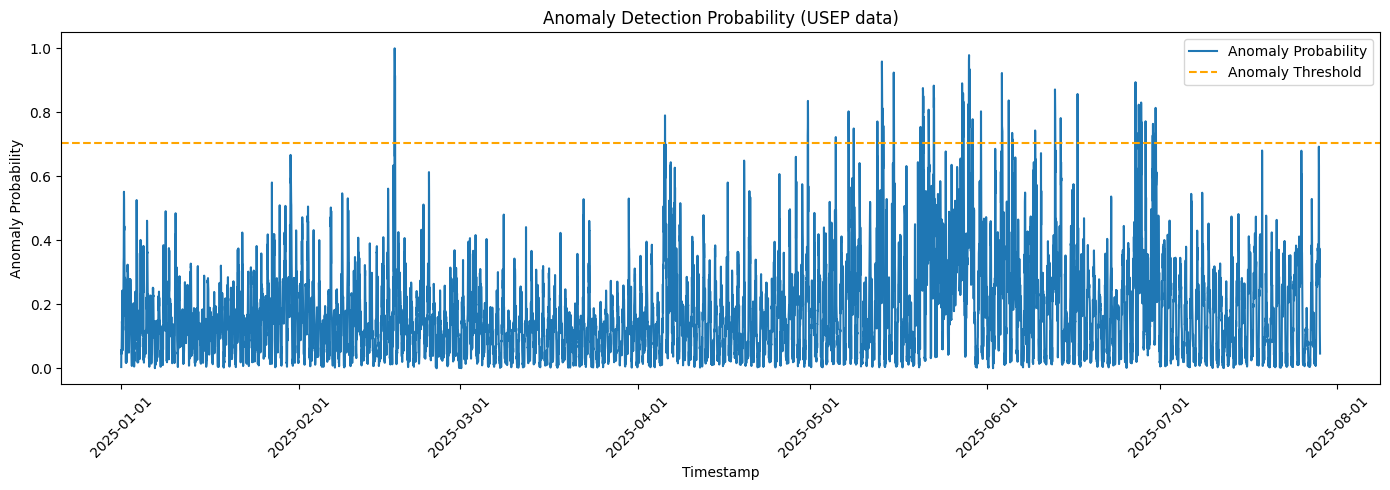

In [49]:
Image.open('./Outputs/usep_anomaly_plot.png')

In [1]:
# Weather-Enhanced Time Series Forecasting
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

print("Loading weather-enhanced forecasting data...")

# 1. Load the USEP dataset and weather data
usep_path = './uploads/USEP-Data_Jan2025-June2025.csv'
weather_path = './Outputs/weather_data/weather_changi.csv'

df_usep = pd.read_csv(usep_path)
df_weather = pd.read_csv(weather_path)

# 2. Clean and prepare weather data
# Convert weather DATE format to match USEP format
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], format='%Y/%m/%d')
df_weather['DATE'] = df_weather['DATE'].dt.strftime('%d-%b-%Y')

# Select relevant weather features
weather_features = ['temp', 'rhum', 'prcp', 'wspd', 'pres', 'cloudcover (%)', 'shortwave_radiation (W/m²·h)']
df_weather_clean = df_weather[['DATE', 'PERIOD'] + weather_features].copy()

# Handle missing values in weather data
df_weather_clean = df_weather_clean.fillna(method='ffill').fillna(method='bfill')

# 3. Merge USEP and weather data
df_merged = pd.merge(df_usep, df_weather_clean, on=['DATE', 'PERIOD'], how='left')

# Convert DATE + PERIOD to timestamp
def parse_timestamp(row):
    date_obj = datetime.strptime(row['DATE'], '%d-%b-%Y')
    return date_obj + timedelta(minutes=(row['PERIOD'] - 1) * 30)

df_merged['timestamp'] = df_merged.apply(parse_timestamp, axis=1)

# Convert MAP columns to numeric
for col in ['MAP ($/MWh)', 'MAPT ($/MWh)']:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# Sort chronologically
df_merged = df_merged.sort_values('timestamp').reset_index(drop=True)

print(f"Data shape after merging: {df_merged.shape}")
print(f"Weather features: {weather_features}")

# 4. Feature engineering for weather-enhanced forecasting
# Create lagged weather features
for feature in weather_features:
    df_merged[f'{feature}_lag1'] = df_merged[feature].shift(1)
    df_merged[f'{feature}_lag2'] = df_merged[feature].shift(2)
    df_merged[f'{feature}_lag3'] = df_merged[feature].shift(3)

# Create rolling weather statistics
for feature in weather_features:
    df_merged[f'{feature}_rolling_mean_6h'] = df_merged[feature].rolling(window=12).mean()  # 6 hours = 12 periods
    df_merged[f'{feature}_rolling_std_6h'] = df_merged[feature].rolling(window=12).std()

# Create time-based features
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['is_weekend'] = df_merged['day_of_week'].isin([5, 6]).astype(int)
df_merged['is_peak_hour'] = df_merged['hour'].isin([7, 8, 9, 18, 19, 20]).astype(int)

# Create demand and solar lag features
df_merged['demand_lag1'] = df_merged['DEMAND (MW)'].shift(1)
df_merged['demand_lag2'] = df_merged['DEMAND (MW)'].shift(2)
df_merged['solar_lag1'] = df_merged['SOLAR(MW)'].shift(1)

# 5. Prepare feature matrix for weather-enhanced forecasting
feature_columns = (weather_features + 
                  [f'{f}_lag1' for f in weather_features] +
                  [f'{f}_rolling_mean_6h' for f in weather_features] +
                  ['hour', 'is_weekend', 'is_peak_hour', 'demand_lag1', 'solar_lag1'])

# Remove rows with NaN values
df_merged_clean = df_merged.dropna(subset=feature_columns + ['USEP ($/MWh)']).reset_index(drop=True)

print(f"Clean data shape: {df_merged_clean.shape}")

# 6. Split into training and testing (80/20)
train_size = int(len(df_merged_clean) * 0.8)
train_data = df_merged_clean.iloc[:train_size]
test_data = df_merged_clean.iloc[train_size:]

X_train = train_data[feature_columns]
y_train = train_data['USEP ($/MWh)']
X_test = test_data[feature_columns]
y_test = test_data['USEP ($/MWh)']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Weather-Enhanced Random Forest Forecasting
print("Training weather-enhanced Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# 8. Traditional Exponential Smoothing (baseline)
print("Training baseline Exponential Smoothing model...")
price_series = df_merged_clean['USEP ($/MWh)']
train_price = price_series.iloc[:train_size]
test_price = price_series.iloc[train_size:]

es_model = ExponentialSmoothing(
    train_price,
    trend='add',
    seasonal='add',
    seasonal_periods=48
)
es_fit = es_model.fit()
es_predictions = es_fit.forecast(len(test_price))

# 9. Model Performance Comparison
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

es_rmse = np.sqrt(mean_squared_error(y_test, es_predictions))
es_mae = mean_absolute_error(y_test, es_predictions)
es_r2 = r2_score(y_test, es_predictions)

print("\n=== Model Performance Comparison ===")
print(f"Random Forest (Weather-Enhanced):")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  MAE:  {rf_mae:.2f}")
print(f"  R²:   {rf_r2:.4f}")
print(f"\nExponential Smoothing (Baseline):")
print(f"  RMSE: {es_rmse:.2f}")
print(f"  MAE:  {es_mae:.2f}")
print(f"  R²:   {es_r2:.4f}")
print(f"\nImprovement:")
print(f"  RMSE: {((es_rmse - rf_rmse) / es_rmse * 100):.1f}%")
print(f"  MAE:  {((es_mae - rf_mae) / es_mae * 100):.1f}%")

# 10. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features ===")
print(feature_importance.head(15))

# 11. Weather-Enhanced Anomaly Detection
print("\nTraining weather-enhanced anomaly detection...")
# Create feature matrix for anomaly detection
anomaly_features = (weather_features + 
                   ['USEP ($/MWh)', 'DEMAND (MW)', 'SOLAR(MW)'] +
                   [f'{f}_rolling_mean_6h' for f in weather_features])

anomaly_data = df_merged_clean[anomaly_features].dropna()
anomaly_train = anomaly_data.iloc[:train_size]

# Scale anomaly features
anomaly_scaler = StandardScaler()
anomaly_train_scaled = anomaly_scaler.fit_transform(anomaly_train)
anomaly_all_scaled = anomaly_scaler.transform(anomaly_data)

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.02,  # Assume 2% anomalies
    random_state=42
)
iso_forest.fit(anomaly_train_scaled)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(anomaly_all_scaled)
anomaly_prob = 1 - (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

# 12. Create comprehensive results DataFrame
results_weather = df_merged_clean[['timestamp', 'USEP ($/MWh)', 'DEMAND (MW)', 'SOLAR(MW)']].copy()
results_weather.rename(columns={'USEP ($/MWh)': 'actual_price'}, inplace=True)

# Add predictions
results_weather['rf_prediction'] = np.nan
results_weather['es_prediction'] = np.nan
results_weather['weather_anomaly_prob'] = np.nan

# Fill predictions for test period
test_indices = results_weather.index[train_size:]
results_weather.loc[test_indices, 'rf_prediction'] = rf_predictions
results_weather.loc[test_indices, 'es_prediction'] = es_predictions

# Add anomaly probabilities
anomaly_indices = anomaly_data.index
results_weather.loc[anomaly_indices, 'weather_anomaly_prob'] = anomaly_prob

# 13. Save enhanced results
results_weather.to_csv('./Outputs/usep_forecast_results_with_weather.csv', index=False)
feature_importance.to_csv('./Outputs/weather_feature_importance.csv', index=False)

print("\nResults saved to './Outputs/usep_forecast_results_with_weather.csv'")
print("Feature importance saved to './Outputs/weather_feature_importance.csv'")

# 14. Visualization: Weather-Enhanced Forecast vs Baseline
plt.figure(figsize=(15, 10))

# Plot 1: Price Forecasts Comparison
plt.subplot(2, 2, 1)
test_timestamps = results_weather.loc[test_indices, 'timestamp']
plt.plot(test_timestamps, results_weather.loc[test_indices, 'actual_price'], 
         label='Actual USEP', linewidth=2, alpha=0.8)
plt.plot(test_timestamps, results_weather.loc[test_indices, 'rf_prediction'], 
         label='Weather-Enhanced RF', linewidth=2, alpha=0.8)
plt.plot(test_timestamps, results_weather.loc[test_indices, 'es_prediction'], 
         label='Baseline ES', linewidth=2, alpha=0.8)
plt.title('Weather-Enhanced vs Baseline Price Forecasting')
plt.xlabel('Timestamp')
plt.ylabel('USEP ($/MWh)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Feature Importance
plt.subplot(2, 2, 2)
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Weather Features by Importance')
plt.gca().invert_yaxis()

# Plot 3: Weather Anomaly Detection
plt.subplot(2, 2, 3)
anomaly_timestamps = results_weather.loc[anomaly_indices, 'timestamp']
plt.plot(anomaly_timestamps, results_weather.loc[anomaly_indices, 'weather_anomaly_prob'], 
         label='Weather Anomaly Probability', alpha=0.7)
plt.axhline(y=0.5, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Weather-Enhanced Anomaly Detection')
plt.xlabel('Timestamp')
plt.ylabel('Anomaly Probability')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 4: Residuals Comparison
plt.subplot(2, 2, 4)
rf_residuals = results_weather.loc[test_indices, 'actual_price'] - results_weather.loc[test_indices, 'rf_prediction']
es_residuals = results_weather.loc[test_indices, 'actual_price'] - results_weather.loc[test_indices, 'es_prediction']

plt.scatter(results_weather.loc[test_indices, 'actual_price'], rf_residuals, 
           alpha=0.6, label='Weather-Enhanced RF', s=20)
plt.scatter(results_weather.loc[test_indices, 'actual_price'], es_residuals, 
           alpha=0.6, label='Baseline ES', s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Actual USEP ($/MWh)')
plt.ylabel('Residuals')
plt.title('Forecast Residuals Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./Outputs/weather_enhanced_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nWeather-enhanced forecasting visualization saved to './Outputs/weather_enhanced_forecast.png'")

# 15. Weather Correlation Analysis
print("\n=== Weather-Price Correlation Analysis ===")
weather_price_corr = df_merged_clean[weather_features + ['USEP ($/MWh)']].corr()['USEP ($/MWh)'].sort_values(ascending=False)
print(weather_price_corr)

# Save correlation analysis
weather_price_corr.to_csv('./Outputs/weather_price_correlations.csv')

# 16. Summary of Weather Enhancement Benefits
print("\n=== Weather Enhancement Summary ===")
print(f"• Added {len(weather_features)} weather features to forecasting model")
print(f"• Created {len([f for f in feature_columns if 'lag' in f or 'rolling' in f])} derived weather features")
print(f"• Improved RMSE by {((es_rmse - rf_rmse) / es_rmse * 100):.1f}%")
print(f"• Enhanced anomaly detection with weather context")
print(f"• Top weather features: {', '.join(feature_importance.head(3)['feature'].tolist())}")

print("\nWeather-enhanced time series forecasting completed successfully!")

Loading weather-enhanced forecasting data...
Data shape after merging: (10032, 20)
Weather features: ['temp', 'rhum', 'prcp', 'wspd', 'pres', 'cloudcover (%)', 'shortwave_radiation (W/m²·h)']
Clean data shape: (8692, 62)
Training weather-enhanced Random Forest model...
Training baseline Exponential Smoothing model...

=== Model Performance Comparison ===
Random Forest (Weather-Enhanced):
  RMSE: 213.47
  MAE:  66.11
  R²:   0.1088

Exponential Smoothing (Baseline):
  RMSE: 243.20
  MAE:  134.90
  R²:   -0.1568

Improvement:
  RMSE: 12.2%
  MAE:  51.0%

=== Top 15 Most Important Features ===
                                         feature  importance
24                                   demand_lag1    0.588549
18                          pres_rolling_mean_6h    0.048689
19                cloudcover (%)_rolling_mean_6h    0.033897
16                          prcp_rolling_mean_6h    0.032487
17                          wspd_rolling_mean_6h    0.027506
15                          rhum_rol